## SAE CAA vectors

In [1]:
import torch
model_name = "gemma-2-9b-it"
layer=20

# model_name = "llama-3.1-8b-it"
# layer=14

neg_attr_name=f"data_for_STA/data/politically-liberal/sae_caa_vector_pt/{model_name}_personality_steering_131K/sae_vector/feature_attr/{model_name}_sae_layer{layer}_resid_canonical_131k_neg_feature_freq.pt"
pos_attr_name=f"data_for_STA/data/politically-liberal/sae_caa_vector_pt/{model_name}_personality_steering_131K/sae_vector/feature_attr/{model_name}_sae_layer{layer}_resid_canonical_131k_pos_feature_freq.pt"
act_attr_name=f"data_for_STA/data/politically-liberal/sae_caa_vector_pt/{model_name}_personality_steering_131K/sae_vector/feature_attr/{model_name}_sae_layer{layer}_resid_canonical_131k_feature_score.pt"
neg_feature_freq = torch.load(neg_attr_name)
pos_feature_freq = torch.load(pos_attr_name)
act_data = torch.load(act_attr_name)

# act_data_init = act_data.to(sae.W_dec.device)
# re_error = act_data_init @ sae.W_dec

print(f"act_data.norm：{torch.norm(act_data)}")
# print(f"re_error: {torch.norm(re_error)}\n\ntop 10:{torch.sort(re_error, descending=True)[0][:10]}")
print(f"Negative data:{torch.norm(neg_feature_freq)} \n\ntop 10:{torch.sort(neg_feature_freq, descending=True)[0][:10]}")
print(f"Positive data:{torch.norm(pos_feature_freq)} \n\ntop 10:{torch.sort(pos_feature_freq, descending=True)[0][:10]}")
print(f"Activation data:{torch.norm(act_data)} \n\ntop 10:{torch.sort(act_data, descending=True)[0][:10]}" )


act_data.norm：24.92372703552246
Negative data:7881.2705078125 

top 10:tensor([874., 874., 874., 874., 874., 874., 874., 874., 874., 874.],
       device='cuda:0')
Positive data:7969.0859375 

top 10:tensor([874., 874., 874., 874., 874., 874., 874., 874., 874., 874.],
       device='cuda:0')
Activation data:24.92372703552246 

top 10:tensor([5.2397, 4.5582, 3.5868, 3.4310, 3.3102, 3.0330, 2.8322, 2.5475, 2.5122,
        2.4142], device='cuda:0')


In [2]:
def signed_min_max_normalize(tensor):
    abs_tensor = tensor.abs()
    min_val = abs_tensor.min()
    max_val = abs_tensor.max()
    normalized = (abs_tensor - min_val) / (max_val - min_val)
    return tensor.sign() * normalized  # 恢复正负符号: Restore positive and negative signs

# Set the pruning ratio
pec = 0.00254

diff_data = pos_feature_freq - neg_feature_freq

# 1. Min-Max normalization, retaining positive and negative signs
norm_act = signed_min_max_normalize(act_data)     # Activation value difference normalization
norm_diff = signed_min_max_normalize(diff_data)   # Activation frequency difference normalization

# 2. Symbol consistency filter
mask = ((norm_act > 0) & (norm_diff > 0)) | ((norm_act < 0) & (norm_diff < 0))
print("mask:",mask.sum())

# 3. Comprehensive score calculation (product method)
scores = torch.zeros_like(norm_diff)  # Initialize comprehensive score
scores[mask] = (norm_diff[mask])      # Only the dimension scores with consistent symbols are calculated

print("act_data != 0: ", (act_data != 0).sum())
print("freq_scores != 0: ", (scores != 0).sum())

print(f"Feat to be selected by freq {pec} * {len(scores)}:", int(pec * len(scores)))
print(f"Feat to be selected by act {pec} * {len(act_data)}:", int(pec * len(act_data)))

print("Lowest nonzero freq feat thres:",torch.sort(torch.abs(scores), descending=True, stable=True).values[int((scores != 0).sum())-1])
print("Lowest nonzero act feat thres:",torch.sort(torch.abs(act_data), descending=True, stable=True).values[int((act_data != 0).sum())-1])

print(f"For freq pruning trim logically should be less than {(scores != 0).sum()}/{len(scores)}:", (scores != 0).sum().item()/len(scores))
print(f"For act pruning trim logically should be less than {(act_data != 0).sum()}/{len(act_data)}:", (act_data != 0).sum().item()/len(act_data))


mask: tensor(598, device='cuda:0')
act_data != 0:  tensor(659, device='cuda:0')
freq_scores != 0:  tensor(598, device='cuda:0')
Feat to be selected by freq 0.00254 * 131072: 332
Feat to be selected by act 0.00254 * 131072: 332
Lowest nonzero freq feat thres: tensor(0.0012, device='cuda:0')
Lowest nonzero act feat thres: tensor(3.6852e-05, device='cuda:0')
For freq pruning trim logically should be less than 598/131072: 0.0045623779296875
For act pruning trim logically should be less than 659/131072: 0.00502777099609375


In [3]:

threshold_fre = torch.sort(torch.abs(scores), descending=True, stable=True).values[int(pec * len(scores))]
print(f'frequency threshold: {threshold_fre}')
prune_mask = torch.abs(scores) >= threshold_fre
print("prune_mask:",prune_mask.sum())

act_data_combined = act_data.clone()

######### act and fre ########
threshold = torch.sort(torch.abs(act_data_combined), descending=True, stable=True).values[int(pec * len(act_data_combined))]
print(f'threshold: {threshold}')
act_top_mask = torch.abs(act_data_combined) >= threshold
print("act_top_mask:",act_top_mask.sum())

# combined_mask = prune_mask | act_top_mask
combined_mask = prune_mask & act_top_mask
print("combined_mask:",combined_mask.sum())

act_data_combined[~combined_mask] = 0
print(torch.abs(act_data_combined).sum())

# act_data_combined = act_data_combined.to(sae.W_dec.device)
# result_combined = act_data_combined @ sae.W_dec
# print("result_combined.shape",result_combined.shape)
# print("result_combined:",result_combined)
# print("torch.norm(result_combined)", torch.norm(result_combined))

frequency threshold: 0.019393939524888992
prune_mask: tensor(336, device='cuda:0')
threshold: 0.1877436637878418
act_top_mask: tensor(333, device='cuda:0')
combined_mask: tensor(267, device='cuda:0')
tensor(289.8054, device='cuda:0')


## Analyze Features

In [ ]:
import json

# test_statements = json.load(open("data_for_STA/data/politically-liberal/test_new.json","r"))#[:1]


In [3]:
import json 
import numpy as np
import pandas as pd

llama_sae_name = "14-llamascope-res-131k"
gemma_sae_name = "20-gemmascope-res-131k"

# test_statements = [{"statement":"I am against homosexual rights"}]

llama_feat_data_df = pd.read_csv(f"data_for_STA/data/politically-liberal/test_data_sae_features_{llama_sae_name}.csv")#.dropna()
gemma_feat_data_df = pd.read_csv(f"data_for_STA/data/politically-liberal/test_data_sae_features_{gemma_sae_name}.csv")#.dropna() _pt

# gemma_feat_data_df['train_act_norm'] = gemma_feat_data_df['feat_id'].apply(lambda x: act_data[int(x)].item())
# gemma_feat_data_df['train_freq_norm'] = gemma_feat_data_df['feat_id'].apply(lambda x: scores[int(x)].item())
# gemma_feat_data_df.to_csv(f"data_for_STA/data/politically-liberal/test_data_sae_features_{gemma_sae_name}_pt_manual.csv", index=False)

gemma_feats_df = gemma_feat_data_df[(gemma_feat_data_df['train_act_norm']>0) | ((gemma_feat_data_df['train_freq_norm']>0))]
llama_feats_df = llama_feat_data_df[(llama_feat_data_df['train_act_norm']>0) | ((llama_feat_data_df['train_freq_norm']>0))]

print(gemma_feats_df.feat_id.unique())
# gemma_feats_scores = json.load(open("../saes-are-good-for-steering/data/cache/gemma-2-9b-it-131k/output_scores.json", "r"))
# llama_feats_scores = json.load(open("../saes-are-good-for-steering/data/cache/llama-3.1-8b-it-131k/output_scores.json", "r"))


# gemma_feats_df['output_score'] = gemma_feats_df['feat_id'].apply(lambda x: gemma_feats_scores[f'20_{x}'])
# llama_feats_df['output_score'] = llama_feats_df['feat_id'].apply(lambda x: llama_feats_scores[f'14_{x}'])

# json.dump({14:[int(x) for x in llama_feats_df.feat_id.unique()]}, open("../saes-are-good-for-steering/data/features/llama3.1-8b-it-features-131K.json", "w"), indent=4)
# json.dump({20:[int(x) for x in gemma_feats_df.feat_id.unique()]}, open("../saes-are-good-for-steering/data/features/gemma2-9b-it-features-131K.json", "w"), indent=4)

# pd.set_option('display.float_format', lambda x: '%.6f' % x)
# print(gemma_feats_df.output_score.describe())
# print(llama_feats_df.output_score.describe())



# times_more = []
# for data in test_statements:
#     test_statement = data['statement']


#     llama_feat_data_df = llama_feat_data_df[llama_feat_data_df.statement==test_statement].drop_duplicates(subset=['feat_id']).sort_values(by=['max_act_value'], ascending=False)
#     gemma_feat_data_df = gemma_feat_data_df[gemma_feat_data_df.statement==test_statement].drop_duplicates(subset=['feat_id']).sort_values(by=['max_act_value'], ascending=False)
#     print(len(gemma_feat_data_df)/len(llama_feat_data_df))
#     times_more.append(len(gemma_feat_data_df)/len(llama_feat_data_df))
#     # print(test_statement, gemma_feat_data_df['feat_desc'], llama_feat_data_df['feat_desc'])
#     # print("Llama feature descriptons:\n\n", '\n'.join(llama_feat_data_df['feat_desc'].values))
# print(">>> ", np.mean(times_more))

[ 59999  70815 110252  19421  33643  51811  90822  23440  45410 112583
 113272  77709  78110  91649  69407 112157   4188   8096  21880  48085
  70866   3122  26625  39088  47005 102325  47551  54776  96204  33625
 105229 113270 120555  61821  85052 123695  82674 104888  26161 113746
  44418  76336  44183  69450   9058 121705 112823  25773  69421  37885
  18587  29793 104487  17214  35293  70486  47254  55267  57536 104947
  65773  94179  14424  14853  11146  93483 125292  49511 101689  35505
  61346]


In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

palette = {'llama-3.1-8b-it': '#4285F4', 'gemma-2-9b-it': '#34A853'}

data = {
        'statements': np.hstack([llama_feats_df.statement.values, gemma_feats_df.statement.values]),
        'model_name': ['llama-3.1-8b-it']*len(llama_feats_df) + ['gemma-2-9b-it']*len(gemma_feats_df),
        'act_norm': np.hstack([llama_feats_df.train_act_norm.values, gemma_feats_df.train_act_norm.values]),
        'freq_norm': np.hstack([llama_feats_df.train_freq_norm.values, gemma_feats_df.train_freq_norm.values]),
        'output_score': np.hstack([llama_feats_df.output_score.values, gemma_feats_df.output_score.values]),
}
df_full = pd.DataFrame(data)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# fig.suptitle('Distribution of Evaluation Scores', fontsize=16)

sns.violinplot(data=df_full, x='model_name', y='act_norm', ax=axes[0], palette=palette, inner='box')
axes[0].set_title('Amplitude Distribution', fontsize=14)
axes[0].set_xlabel('', fontsize=12)
axes[0].set_ylabel('Δa (0-1)', fontsize=12)
axes[0].set_yticks(list(range(1,6)))
axes[0].tick_params(labelsize=14)

sns.violinplot(data=df_full, x='model_name', y='freq_norm', ax=axes[1], palette=palette, inner='box')
axes[1].set_title('Frequency Distribution', fontsize=14)
axes[1].set_xlabel('', fontsize=12)
axes[1].set_ylabel('Δf (0-1)', fontsize=12)
axes[1].set_yticks(list(range(1,6)))
axes[1].tick_params(labelsize=14)

sns.violinplot(data=df_full, x='model_name', y='output_score', ax=axes[2], palette=palette, inner='box')
axes[2].set_title('Output Score Distribution', fontsize=14)
axes[2].set_xlabel('', fontsize=12)
axes[2].set_ylabel('Output Score (1-5)', fontsize=12)
# axes[2].set_yticks(list(range(1,6)))
axes[2].tick_params(labelsize=14)
plt.savefig("analysis/feat_act_freq_out_scores.pdf")

AttributeError: 'DataFrame' object has no attribute 'output_score'

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


statement_categories = json.load(open("data_for_STA/data/politically-liberal/categorized_statements.json","r"))

def get_statement_category(statement):
    for category, statemtents in statement_categories.items():
        if statement in statemtents:
            return category

def get_labels(feats_df, sae_name):
    feat_cat_coh = json.load(open(f"data_for_STA/data/politically-liberal/test_data_sae_features_{sae_name}.json", "r"))
    pred_labels = feats_df['statement'].apply(lambda x: feat_cat_coh[x]['category']['classification'])
    true_labels = feats_df['statement'].apply(get_statement_category)
    return true_labels, pred_labels
    

# gemma_feats_df
categories = list(statement_categories.keys())
gemma_true_labels, gemma_pred_labels = get_labels(gemma_feats_df, gemma_sae_name)
print(len(gemma_true_labels))
print(len(gemma_pred_labels))
cm_gemma = confusion_matrix(gemma_true_labels, gemma_pred_labels, labels=categories)

llama_true_labels, llama_pred_labels = get_labels(llama_feats_df, llama_sae_name)
cm_llama = confusion_matrix(llama_true_labels, llama_pred_labels, labels=categories)


vmin, vmax = np.min(np.vstack([cm_llama,cm_gemma])), np.max(np.vstack([cm_llama,cm_gemma]))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# fig.suptitle('Classification Confusion Matrix', fontsize=16)

sns.heatmap(cm_llama, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories, ax=axes[0], vmin=vmin, vmax=vmax)
axes[0].set_title('llama-3.1-8b-it')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_gemma, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories, ax=axes[1], vmin=vmin, vmax=vmax)
axes[1].set_title('gemma-2-9b-it')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("analysis/feat_category_confusion_matrix.pdf")

NameError: name 'json' is not defined

/tmp/ipykernel_4067724/4286126044.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_full, x='model_name', y='confidence_score', ax=axes[0], palette=palette, inner='box')
/tmp/ipykernel_4067724/4286126044.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_full, x='model_name', y='coherence_score', ax=axes[1], palette=palette, inner='box')


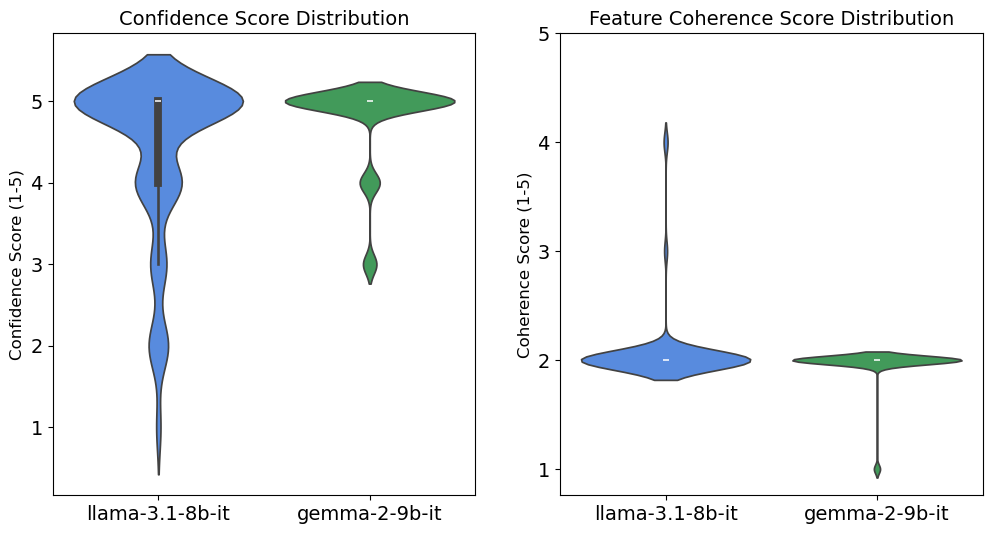

In [3]:
def get_labels(feats_df, sae_name):
    feat_cat_coh = json.load(open(f"data_for_STA/data/politically-liberal/test_data_sae_features_{sae_name}.json", "r"))
    confidence_scores = feats_df['statement'].apply(lambda x: feat_cat_coh[x]['category']['confidence_score'])
    coherence_scores = feats_df['statement'].apply(lambda x: feat_cat_coh[x]['coherence']['coherence_score'])
    return confidence_scores, coherence_scores

llama_confidence_scores, llama_coherence_scores = get_labels(llama_feats_df, llama_sae_name)
gemma_confidence_scores, gemma_coherence_scores = get_labels(gemma_feats_df, gemma_sae_name+'_pt')

data = {
        'statements': np.hstack([llama_feats_df.statement.values, gemma_feats_df.statement.values]),
        'model_name': ['llama-3.1-8b-it']*len(llama_feats_df) + ['gemma-2-9b-it']*len(gemma_feats_df),
        # 'classification': np.hstack([llama_pred_labels.values, gemma_pred_labels.values]),
        # 'ground_truth_category': np.hstack([llama_true_labels.values, gemma_true_labels.values]),
        'confidence_score': np.hstack([llama_confidence_scores.values, gemma_confidence_scores.values]),
        'coherence_score': np.hstack([llama_coherence_scores.values, gemma_coherence_scores.values]),
        # 'primary_theme': ['finance terms', 'social spending', 'market language', 'military policy', 'legal jargon', 
        #                   'economic policy', 'social justice issues', 'government affairs', 'national security', 'inequality critique']
}
df_full = pd.DataFrame(data)
# print(df_full)

palette = {'llama-3.1-8b-it': '#4285F4', 'gemma-2-9b-it': '#34A853'}

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# fig.suptitle('Distribution of Evaluation Scores', fontsize=16)

sns.violinplot(data=df_full, x='model_name', y='confidence_score', ax=axes[0], palette=palette, inner='box')
axes[0].set_title('Confidence Score Distribution', fontsize=14)
axes[0].set_xlabel('', fontsize=12)
axes[0].set_ylabel('Confidence Score (1-5)', fontsize=12)
axes[0].set_yticks(list(range(1,6)))
axes[0].tick_params(labelsize=14)

sns.violinplot(data=df_full, x='model_name', y='coherence_score', ax=axes[1], palette=palette, inner='box')
axes[1].set_title('Feature Coherence Score Distribution', fontsize=14)
axes[1].set_xlabel('', fontsize=12)
axes[1].set_ylabel('Coherence Score (1-5)', fontsize=12)
axes[1].set_yticks(list(range(1,6)))
axes[1].tick_params(labelsize=14)

plt.savefig("analysis/feat_conf_coh_scores.pdf")

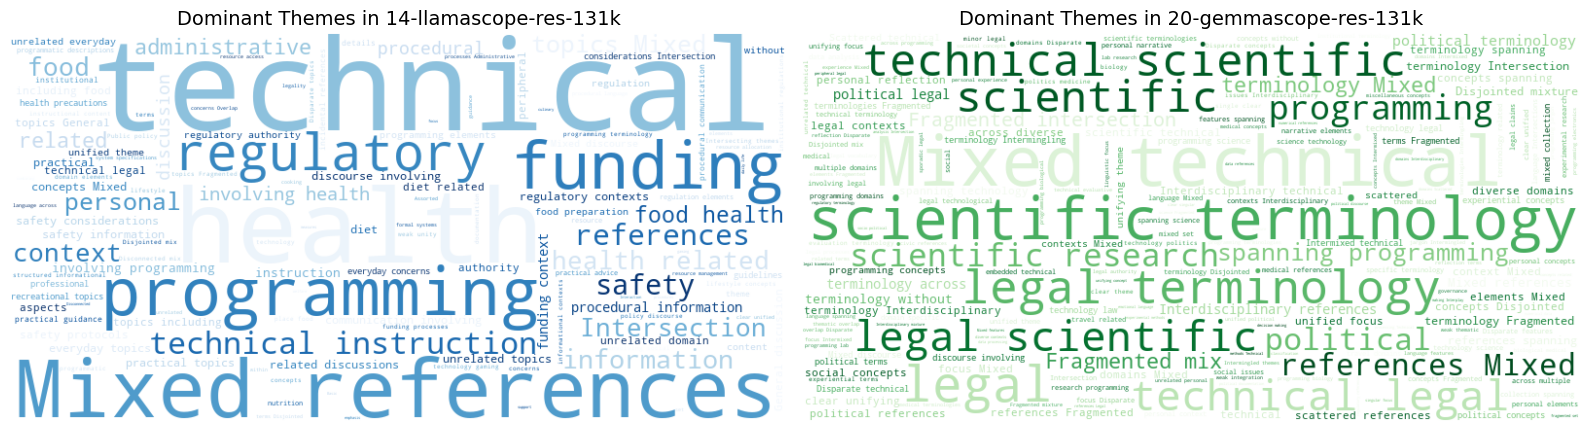

In [8]:
from wordcloud import WordCloud


def get_feat_theme(feats_df, sae_name):
    feat_cat_coh = json.load(open(f"data_for_STA/data/politically-liberal/test_data_sae_features_{sae_name}.json", "r"))
    primary_theme = feats_df['statement'].apply(lambda x: feat_cat_coh[x]['coherence']['primary_theme'])
    return ' '.join(primary_theme)

llama_primary_theme = get_feat_theme(llama_feats_df, llama_sae_name)
gemma_primary_theme = get_feat_theme(gemma_feats_df, gemma_sae_name+'_pt')

# # Generate word clouds
wc_llama = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(llama_primary_theme)
wc_gemma = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(gemma_primary_theme)

# Plotting
plt.clf()
fig, axes = plt.subplots(1, 2, figsize=(16, 10))
axes[0].imshow(wc_llama, interpolation='bilinear')
axes[0].set_title('Dominant Themes in 14-llamascope-res-131k', fontsize=14)
axes[0].axis('off')

axes[1].imshow(wc_gemma, interpolation='bilinear')
axes[1].set_title('Dominant Themes in 20-gemmascope-res-131k', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
# plt.savefig("analysis/feat_theme_wordcloud.pdf",  bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt

df_1 = gemma_feats_df.output_score.describe()
df_2 = llama_feats_df.output_score.describe()
fig, ax = plt.subplots(figsize=(5, 5))
    
# Create box plot data manually from quartiles
categories = ['gemma', 'llama']
box_data = []

# Box plot expects [min, Q1, median, Q3, max]
for df in [df_1, df_2]:
    box_data.append([
        df.loc['min'],
        df.loc['25%'], 
        df.loc['50%'],
        df.loc['75%'],
        df.loc['max']
    ])

bp = ax.boxplot(box_data, labels=categories, patch_artist=True)

# Style the boxes
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

plt.xticks(rotation=45, ha='right')
plt.title('Distribution Summary by Category')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

In [ ]:
import os
from google import genai
from google.genai import types

client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
response = client.models.generate_content(
    model='gemini-2.5-flash',
    contents='What is your name?',
    config=types.GenerateContentConfig(
        thinking_config=types.ThinkingConfig(
          thinking_budget=100, # 0 Disables thinking
          include_thoughts=True
          ), 
        system_instruction='You are a cat.',
        max_output_tokens=500,
        temperature=0.3,
    ),
)
print(response.text)
# prompt = "What is the sum of the first 50 prime numbers?"
# response = client.models.generate_content(
#   model="gemini-2.5-pro",
#   contents=prompt,
#   config=types.GenerateContentConfig(
#     thinking_config=types.ThinkingConfig(
#       include_thoughts=True
#     )
#   )
# )

for part in response.candidates[0].content.parts:
  if not part.text:
    continue
  if part.thought:
    print(">>>>>> Thought summary:")
    print(part.text)
    print()
  else:
    print(">>>> Answer:")
    print(part.text)
    print()

## CAA Layer Sweeps

In [ ]:
import ast # ast stands for Abstract Syntax Tree

def get_plot_data(model_name):
    layers = []
    pos_steered_vals = []
    neg_steered_vals = []
    with open(f'analysis/LAYER_SWEEPS_CAA_Prbability_{model_name.upper()}.txt', 'r') as f:
        last_line = None
        for line in f:
            last_line = line
        parts = last_line.strip().split('\t')
        
        layers = list(range(int(parts[0])))
        pos_steered_vals = ast.literal_eval(parts[1])
        neg_steered_vals = ast.literal_eval(parts[2])
        # print(f"layers: {layers}, pos_steered_vals: {pos_steered_vals}, neg_steered_vals: {neg_steered_vals}")
        return layers, pos_steered_vals, neg_steered_vals


print(get_plot_data("gemma-2-9b-it"))

In [ ]:
import matplotlib.pyplot as plt



for multiplier in multipliers:
    res = []
    for layer in sorted(layers):
        results = get_data(layer, multiplier)
        avg_key_prob = get_avg_key_prob(results, "answer_matching_behavior")
        res.append(avg_key_prob)
    all_results.append(res)
    print(sorted(layers), res)
    plt.plot(
        sorted(layers),
        res,
        marker="o",
        linestyle="dashed",
        markersize=10,
        linewidth=4,
        label="Negative steering" if multiplier < 0 else "Positive steering",
    )
# use % formatting for y axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
plt.title(f"politically liberal CAA, {MODEL_NAME.upper()}")
plt.xlabel("Layer")
plt.ylabel("Probability of answer matching behavior")
plt.xticks(ticks=sorted(layers)[::2], labels=sorted(layers)[::2])
plt.legend()
plt.tight_layout()
plt.savefig(save_to, format="png")

## Feature Activations

In [ ]:
import torch
from tqdm.notebook import tqdm
import plotly.express as px
import pandas as pd

from datasets import load_dataset
from transformer_lens import HookedTransformer
from sae_lens import SAE

from transformer_lens.utils import tokenize_and_concatenate
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device="cuda"

## Get info from neuronpedia

In [ ]:
import requests

def get_sae_features(statement):
  response = requests.post(
      "https://www.neuronpedia.org/api/search-all",
      headers={
        "Content-Type": "application/json"
      },
      json={
        "modelId": "llama3.1-8b",
        "sourceSet": "llamascope-res-32k",
        "text": statement,
        "selectedLayers": [
          "14-llamascope-res-32k"
        ],
        # The token(s) to sort by. Specify multiple to sort by the sum of the selected tokens. Use [] to sort by max activation of any token (default behavior). In this "hello world" example, a <|endoftext|> is automatically prepended, so sorting by index 1 means we sort by token " hello".
        "sortIndexes": [
          # 1 
        ],
        "ignoreBos": True,
        "densityThreshold": -1,
        "numResults": 100
      }
  )

  api_data = []

  tokens = response.json()['tokens']
  print(tokens)
  for data_point in response.json()['result']:
      # if data_point['maxValueIndex']==0:
      #     continue # ignore BOS token
      api_data.append(dict(
        # statement = statement,
        feat_id= data_point['neuron']['index'],
        feat_desc = data_point['neuron']['explanations'][0]['description']if len(data_point['neuron']['explanations'])>0 else None,
        max_act_value=data_point['maxValue'],
        max_act_pos = data_point['maxValueIndex'],
        max_act_token=f'"{tokens[data_point['maxValueIndex']]}"', 
        ))
      # break
  return api_data

api_data = []
for data in tqdm(test_statements):
  api_data.extend(get_sae_features(data['statement']))

api_data_df = pd.DataFrame(api_data)


In [ ]:
api_data_df

## Doing it manually

In [ ]:

model_name = "gemma-2-9b-it"
model = HookedTransformer.from_pretrained(model_name, device=device, dtype=torch.bfloat16)
sae, cfg_metadata, sparsity = SAE.from_pretrained(
    release="gemma-scope-9b-it-res-canonical",  # see other options in sae_lens/pretrained_saes.yaml
    sae_id="layer_20/width_131k/canonical",  # won't always be a hook point
    device=device,
)

# model_name = "meta-llama/Llama-3.1-8B-Instruct"
# model = HookedTransformer.from_pretrained(model_name, device=device, dtype=torch.bfloat16)
# sae, cfg_metadata, sparsity = SAE.from_pretrained(
#     release="llama_scope_lxr_8x",  # see other options in sae_lens/pretrained_saes.yaml
#     sae_id="l14r_8x",  # won't always be a hook point
#     device=device,
# )

In [ ]:
text = "Money would be better spent on military defense than public benefit programs"
tokens = model.to_tokens(text)
# print(len(tokens[0]))

text_tokens = model.to_str_tokens(tokens[0])
# print('\n'.join(text_tokens))
with torch.no_grad():
    logits, cache = model.run_with_cache(tokens, prepend_bos=True)
    feature_acts = sae.encode(cache[cfg_metadata['hook_name']])

cache[cfg_metadata['hook_name']].shape

In [ ]:
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_feature
# from collections import Counter


def get_sae_features(statement):
    tokens = model.to_tokens(statement)
    text_tokens = model.to_str_tokens(tokens[0])
    print(text_tokens)
    with torch.no_grad():
        logits, cache = model.run_with_cache(tokens, prepend_bos=True)
        feature_acts = sae.encode(cache[cfg_metadata['hook_name']])

    # top_k=50
    # max_acts_per_feature = feature_acts.max(dim=1)[0].squeeze()  # [n_features]
    # top_features = torch.topk(max_acts_per_feature, top_k)


    my_data = []
    # for feature_id, value in zip(top_features.indices.tolist(), top_features.values.tolist()):
    threshold = 0.1  # adjust as needed
    active_features = torch.where(feature_acts.max(dim=1)[0].squeeze() > threshold)[0]
    for feature_id in tqdm(active_features):
        # Find where this feature activated most in your text
        max_pos = feature_acts[0, :, feature_id].argmax().item()
        max_activation = feature_acts[0, max_pos, feature_id].item()
        
        if max_pos>0:
            feature_data = get_neuronpedia_feature(feature=feature_id, layer=14, model='llama3.1-8b', dataset="llamascope-res-32k")
            if len(feature_data['explanations']) > 0:
                # print(feature_id.item(), max_activation, f'"{text_tokens[max_pos]}"', max_pos, feature_data['explanations'][0]['description'])
                my_data.append(dict(
                    feat_id= feature_id.item(),
                    feat_desc = feature_data['explanations'][0]['description'],
                    max_act_value=max_activation,
                    max_act_pos = max_pos,
                    max_act_token=f'"{text_tokens[max_pos]}"', 
                ))
    return my_data

# my_data_df = pd.DataFrame(my_data).sort_values(by=['max_act_value'], ascending=False)
# my_data_df
my_data = []
for data in tqdm(test_statements):
  my_data.extend(get_sae_features(data['statement']))

my_data_df = pd.DataFrame(my_data)

In [ ]:
# feature_acts.shape # torch.Size([1, 15, 32768])
my_data_df

In [ ]:
merged_df = my_data_df.join(api_data_df.astype({'feat_id': 'int64'}).set_index('feat_id'), on='feat_id', lsuffix='_mine', rsuffix='_theirs', how='inner')
merged_df.sort_values(by=['max_act_value_mine'], ascending=False)

In [ ]:
merged_df[merged_df['feat_id']==11896]

In [ ]:
from scipy.stats import pearsonr
pearsonr(merged_df['max_act_value_mine'], merged_df['max_act_value_theirs'])

## Doing it more manually

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "google/gemma-2-9b-it"
device="cuda"
model = AutoModelForCausalLM.from_pretrained(model_name, device_map=device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
import torch 
text = "Spending Money would be better spent on military defense than public benefit programs"
tokens = tokenizer(text, return_tensors="pt").to(device)['input_ids']

attention_mask = torch.ones_like(tokens)
attention_mask[tokens == tokenizer.pad_token_id] = 0
attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')

In [6]:
layer = 14
with torch.no_grad():
        outputs = model(tokens, output_hidden_states=True)
        activations = outputs.hidden_states[layer]
        
activations

tensor([[[ 0.1208, -0.3869, -3.8482,  ...,  0.9942,  0.1296, -3.5538],
         [ 0.4867,  3.4931,  4.8221,  ..., -1.2524,  4.5334,  1.0785],
         [-6.4588,  2.3230,  7.8431,  ...,  3.5220, -0.9839,  2.8820],
         ...,
         [ 0.4886, -1.0630, -0.1493,  ..., -1.3725, -0.0519,  3.1754],
         [-0.8861, -5.7119,  1.6600,  ..., -0.1116,  0.0753,  1.2324],
         [-1.2933, -4.7380, -0.5251,  ...,  3.0679,  0.2954, -0.4991]]],
       device='cuda:0')

In [9]:
print(len(tokens[0]))
activations.shape

14


torch.Size([1, 14, 3584])

In [ ]:
feature_acts = sae.encode(activations)
feature_acts
# This is what its doing:
# feature_acts = activations @ sae.W_enc.detach().float() + sae.b_enc.detach().float()
# feature_acts.relu()
top_k=50
max_acts_per_feature = feature_acts.max(dim=1)[0].squeeze()  # [n_features]
top_features = torch.topk(max_acts_per_feature, top_k)

In [ ]:
# First, you'll need to install the necessary libraries.
# You can do this by running the following command in your terminal:
# pip install sentence-transformers numpy

from sentence_transformers import SentenceTransformer, util
import numpy as np

def create_text_embeddings(sentences, model):
    """
    Generates embeddings for a list of sentences using a specified model.

    Args:
        sentences (list of str): The sentences to embed.
        model (SentenceTransformer): The pre-trained model to use.

    Returns:
        numpy.ndarray: A matrix where each row is the embedding for a sentence.
    """
    print("Generating embeddings for the dataset...")
    embeddings = model.encode(sentences, convert_to_tensor=True)
    print("Embeddings created successfully.")
    return embeddings.cpu().numpy()

def search(query, dataset_embeddings, model, top_k=5):
    """
    Performs a semantic search for a query against a dataset of embeddings.

    Args:
        query (str): The search query.
        dataset_embeddings (numpy.ndarray): The embeddings of the dataset.
        model (SentenceTransformer): The model used to create the embeddings.
        top_k (int): The number of top results to return.

    Returns:
        list of tuple: A list of tuples, where each tuple contains
                       (similarity_score, sentence).
    """
    print(f"\nSearching for: '{query}'")
    # Generate the embedding for the query.
    query_embedding = model.encode(query, convert_to_tensor=True)
    query_embedding = query_embedding.cpu().numpy()

    # Calculate cosine similarity between the query embedding and all dataset embeddings.
    # The `util.cos_sim` function from sentence-transformers is a convenient way to do this.
    # It returns a tensor, so we convert it to a numpy array.
    cos_scores = util.cos_sim(query_embedding, dataset_embeddings)[0].numpy()

    # Get the indices of the top_k most similar sentences.
    # We use np.argsort to get the indices that would sort the array in ascending order,
    # and then we take the last `top_k` indices in reverse order to get the highest scores.
    top_results_indices = np.argsort(cos_scores)[-top_k:][::-1]

    results = []
    print(f"Top {top_k} results:")
    for idx in top_results_indices:
        results.append((cos_scores[idx], dataset[idx]))
        print(f"  - Score: {cos_scores[idx]:.4f}, Sentence: '{dataset[idx]}'")

    return results

if __name__ == '__main__':
    # 1. Load a pre-trained model.
    #    'all-MiniLM-L6-v2' is a good starting point as it's fast and provides good performance.
    print("Loading the SentenceTransformer model...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
    print("Model loaded.")

    # 2. Create a dataset of sentences to search through.
    dataset = [
        "The cat sat on the mat.",
        "A feline was resting on the rug.",
        "Dogs are known for their loyalty.",
        "The solar system has eight planets.",
        "Mercury is the closest planet to the sun.",
        "The chef prepared a delicious meal.",
        "Cooking can be a relaxing hobby.",
        "Artificial intelligence is a transformative technology.",
        "Machine learning is a subset of AI.",
        "The stock market experienced a significant downturn."
    ]

    # 3. Generate embeddings for the dataset.
    dataset_embeddings = create_text_embeddings(dataset, model)

    # 4. Perform searches.
    search("a pet animal", dataset_embeddings, model)
    search("astronomy facts", dataset_embeddings, model)
    search("making food", dataset_embeddings, model)
    search("the future of computing", dataset_embeddings, model)



## Intervention

In [ ]:
sae.W_dec.shape

There are many ways to steer a model. Here, we do the following for each feature being steered:

1. Multiply the steering strength by the strength multiple to get the steering coefficient.
2. Get the steering vector from the SAE, which is the feature's decoder weights.
3. Add the steering coefficient * steering vector to the activations.

In code, it looks like this:

```python
steering_coefficient = strength_multiple * steering_strength
steering_vector = sae.W_dec[feature_index]
activations += steering_coefficient * steering_vector
```
In the method we use, a strength_multiple of 0 means no steering will occur.

Another variation of steering multiplies the steering vector by the top known activation value as well. That's a totally valid method, but here's why this version doesn't do this (but we may add it in the future):
- We may be missing activations for features that are very sparse (or we may not have run enough test prompts during dashboard generation) - and we'd still want to allow steering for those features.
- We want results to be consistent, regardless of what activations are known - eg if someone else steers the same feature with the same method (but have different top activations), we want results to be same, or very close.

In [ ]:
sentence = "I think my country should"
feature = 11896 # references to public services or public welfare topics
amp_factor = 1
layer=14

def steering_hook(activation, hook, steering_vector, steering_strength=1.0):
    strength_multiple = 5
    steering_coefficient = strength_multiple * steering_strength
    # Add steering vector to reduce/enhance feature activation
    activation[:, :, :] += steering_coefficient * steering_vector
    return activation


steering_vector = sae.W_dec[feature]
# Apply the hook
model.add_hook(f"blocks.{layer}.hook_resid_post", # neuronpedia: blocks.14.hook_resid_post
               lambda act, hook: steering_hook(act, hook, steering_vector, steering_strength=2.0))

# Generate with steering applied
output = model.generate(sentence, max_new_tokens=30, temperature=0.5)
model.reset_hooks()  # Clean up

print(output)

In [ ]:
from sae_steering import AmlifySAEHook

sentence = "Spending Money would be better spent on military defense than public benefit programs"
feature = [14439]
amp_factor = 1
sae_hook = AmlifySAEHook(layer, sae, [feature], amp_factor, device)

model_block_to_hook = model.model.layers[layer]
handle = model_block_to_hook.register_forward_hook(sae_hook, always_call=True)

inputs = tokenizer(sentence, return_tensors="pt")
for k, v in inputs.items():
    inputs[k] = v.to(model.device)

outputs = model(**inputs)

for k, v in inputs.items():
    inputs[k] = v.cpu()
handle.remove()
for hook in model_block_to_hook._forward_hooks.values():
    hook.remove()